In [ ]:
import json
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
from toolz import pipe

from pyrlmala.learning import LearningFactory
from pyrlmala.utils import Toolbox

In [2]:
plot_agent_100 = partial(Toolbox.plot_agent, steps_per_episode=100)

In [3]:
stan_code_path = "banana.stan"
stan_data_path = "banana.json"

with open(stan_data_path, "r") as f:
    data = json.load(f)

    log_target_pdf = Toolbox.make_log_target_pdf(stan_code_path, data)
    grad_log_target_pdf = Toolbox.make_grad_log_target_pdf(stan_code_path, data)

/home/congye/Code/PythonProjects/pyrlmala/.venv/lib/python3.12/site-packages/bridgestan/model.py:140: UserWarning: Loading a shared object /home/congye/Code/PythonProjects/pyrlmala/demo/banana/banana_model.so that has already been loaded.
If the file has changed since the last time it was loaded, this load may not update the library!
  warnings.warn(


In [4]:
sample_dim = 2
initial_sample = np.zeros(sample_dim)
algorithm = "ddpg"

learning_instance = LearningFactory.create_learning_instance(
    algorithm=algorithm,
    log_target_pdf=log_target_pdf,
    grad_log_target_pdf=grad_log_target_pdf,
    initial_sample=initial_sample,
    hyperparameter_config_path="../../config/td3.toml",
    actor_config_path="../../config/actor.toml",
    critic_config_path="../../config/critic.toml",
)

In [5]:
learning_instance.train()

  0%|          | 0/50000 [00:00<?, ?it/s]

/home/congye/Code/PythonProjects/pyrlmala/src/pyrlmala/envs/env.py:180: RuntimeWarning: divide by zero encountered in log1p
  log_one_minus_alpha = np.log1p(-np.exp(log_alpha))


In [ ]:
# learning_instance.predict()

In [ ]:
accepted_sample = getattr(learning_instance, "env").envs[0].unwrapped.store_accepted_sample

plt.plot(accepted_sample[:, 0], accepted_sample[:, 1], 'o-', alpha=0.1)
plt.show()

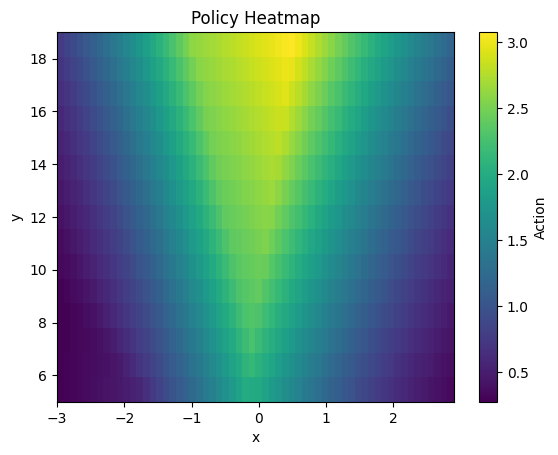

In [18]:
x_range = (-3, 3, 0.1)
y_range = (5, 20, 1)
policy = lambda x: learning_instance.actor(x.double())

Toolbox.policy_plot_2D_heatmap(policy, torch.arange(*x_range), torch.arange(*y_range))

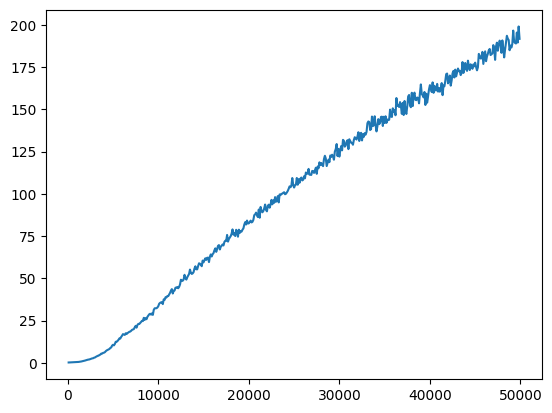

In [ ]:
pipe(learning_instance, lambda x: getattr(x, "critic_values"), plot_agent_100)

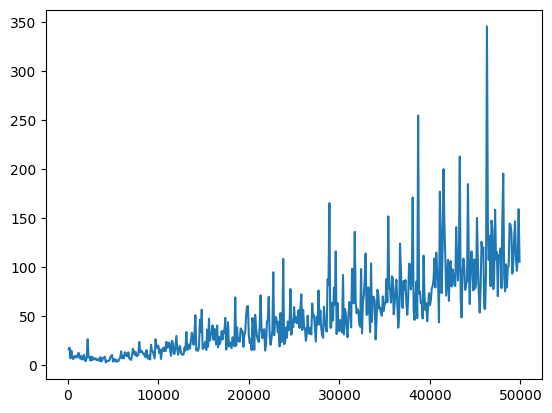

In [ ]:
pipe(learning_instance, lambda x: getattr(x, "critic_loss"), plot_agent_100)

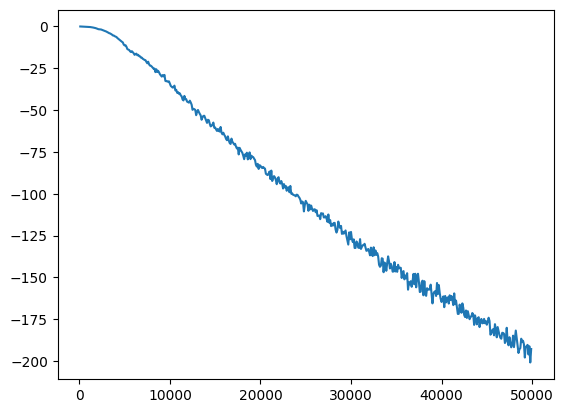

In [ ]:
pipe(learning_instance, lambda x: getattr(x, "actor_loss"), plot_agent_100)